In [1]:
!nvidia-smi

Mon Aug 29 12:04:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.15       Driver Version: 512.15       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000   WDDM  | 00000000:01:00.0  On |                  Off |
| 30%   37C    P8    13W / 230W |  14975MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import pandas as pd
import shutil, time, os, requests, random, copy
from itertools import permutations 
import seaborn as sns
import imageio
from skimage.transform import rotate, AffineTransform, warp, resize
#from google.colab.patches import cv2_imshow
from IPython.display import clear_output, Image, SVG
import h5py

from typing import Optional, Any
from tqdm import tqdm
#%tensorflow_version 2.x
#%load_ext tensorboard
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader



from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
#import matplotlib.animation as animation
%matplotlib inline

In [3]:
def seed_everything(seed, workers = True):
    print(f"Global seed set to {seed}")
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    #os.environ["CUDA_LAUNCH_BLOCKING"] = str(1)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PL_SEED_WORKERS"] = f"{int(workers)}"

def save_model(model, current_epoch, save_path, name):
    out = os.path.join(save_path,name.format(current_epoch))

    torch.save({'model_state_dict': model.state_dict()}, out)

    return out

def load_model(model, model_path):
    state = torch.load(model_path)
    model.load_state_dict(state['model_state_dict'], strict = False)

def plot_features(feats, labels, num_classes, epoch):
    tsne = TSNE(n_components = 2, perplexity = 50)
    x_feats = tsne.fit_transform(feats)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(1,1,1)
    for i in range(num_classes):
        #plt.scatter(x_feats[val_df['class'].iloc[:num_samples].values==i,1],x_feats[val_df['class'].iloc[:num_samples].values==i,0])
        ax.scatter(x_feats[labels==i,1],x_feats[labels==i,0])
    ax.legend([str(i) for i in range(num_classes)])
    ax.set_title('TSNE-fied fearures of Pre-train model at Epoch : '+str(epoch))
    #plt.show()
    return fig

def plot_metrics(tr, val, title):
    fig= pltfigure(figsize=(50,50))
    ax = fig.add_subplot(1,1)
    t = ax.plot(tr, 'r-', label = 'train')
    v = ax.plot(val, 'b-', label = 'valid')
    ax.legend(handles = [t,v]) #, labels = ['train','valid'])
    ax.set_title(title)
    plt.show()
    return fig

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def adjust_learning_rate(optimizer, epoch, args):
    """Decay the learning rate based on schedule"""
    lr = args.lr
    if args.cos:  # cosine lr schedule
        lr *= 0.5 * (1. + math.cos(math.pi * epoch / args.epochs))
    else:  # stepwise lr schedule
        for milestone in args.schedule:
            lr *= 0.1 if epoch >= milestone else 1.
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [4]:
seed_everything(0)

Global seed set to 0


In [5]:
#!wget http://download.cs.stanford.edu/deep/MRNet-v1.0.zip

In [6]:
#!zip -FFv MR.zip --out MRNet.zip

In [7]:
#!unzip MRNet.zip -d ~/MRNet

## Files

In [8]:
mrnet_path = 'C:/Users/ISI_UTS/Siladittya/Datasets/MRNet-v1.0/MRNet-v1.0'
contents = os.listdir(mrnet_path)
print(contents)
print('\nLabel Files...')
label_files = [x for x in contents if x.endswith('.csv')]
print(label_files)

['train', 'train-abnormal.csv', 'train-acl.csv', 'train-meniscus.csv', 'valid', 'valid-abnormal.csv', 'valid-acl.csv', 'valid-meniscus.csv']

Label Files...
['train-abnormal.csv', 'train-acl.csv', 'train-meniscus.csv', 'valid-abnormal.csv', 'valid-acl.csv', 'valid-meniscus.csv']


In [9]:
# #Needs to be done once
# classes = ['axial','sagittal','coronal']
# fileToBeDeleted = '.DS_Store'
# for c in classes:
#     os.remove(mrnet_path+'/train/'+c+'/'+fileToBeDeleted)
# print(fileToBeDeleted in os.listdir(mrnet_path+'/train/axial'))
# print(fileToBeDeleted in os.listdir(mrnet_path+'/train/sagittal'))
# print(fileToBeDeleted in os.listdir(mrnet_path+'/train/coronal'))

### Real Labels

In [10]:
#For Colab /root/MRNet/MRNet-v1.0/
trabn = pd.read_csv(mrnet_path+'/train-abnormal.csv',header=None)
#trabn.head()
tracl = pd.read_csv(mrnet_path+'/train-acl.csv',header=None)
#tracl.head()
trmen = pd.read_csv(mrnet_path+'/train-meniscus.csv',header=None)
#trmen.head()

In [11]:
trabn.columns = ['patient_id','label']
tracl.columns = ['patient_id','label']
trmen.columns = ['patient_id','label']

In [12]:
tr_multilabel = trabn.merge(tracl,on='patient_id').merge(trmen,on='patient_id')
tr_multilabel.columns = ['patient_id','abn','acl','men']
tr_multilabel.head()

,patient_id,abn,acl,men
0,0,1,0,0
1,1,1,1,1
2,2,1,0,0
3,3,1,0,1
4,4,1,0,0


In [13]:
tr_multilabel.to_csv('tr_multilabl.csv',header=True)

In [14]:
#For Colab /root/MRNet/MRNet-v1.0/
valabn = pd.read_csv(mrnet_path+'/valid-abnormal.csv',header=None)
valacl = pd.read_csv(mrnet_path+'/valid-acl.csv',header=None)
valmen = pd.read_csv(mrnet_path+'/valid-meniscus.csv',header=None)

In [15]:
valabn.columns = ['patient_id','label']
valacl.columns = ['patient_id','label']
valmen.columns = ['patient_id','label']

In [16]:
val_multilabel = valabn.merge(valacl,on='patient_id').merge(valmen,on='patient_id')
val_multilabel.columns = ['patient_id','abn','acl','men']
val_multilabel.head(120)

,patient_id,abn,acl,men
0,1130,0,0,0
1,1131,0,0,0
2,1132,0,0,0
3,1133,0,0,0
4,1134,0,0,0
...,...,...,...,...
115,1245,1,1,1
116,1246,1,1,1
117,1247,1,0,1
118,1248,1,1,1


### <font color='blue'>Filename DataFrame</font>

In [17]:
tr_filenames_df = pd.DataFrame(columns=['filename'])
tr_filenames_df['filename'] = os.listdir(mrnet_path+'/train/axial')
tr_filenames_df['patient_id'] = tr_filenames_df.apply(lambda x : int(x['filename'][:-4]),axis=1)
tr_filenames_df = tr_filenames_df[list(('patient_id','filename'))]
tr_filenames_df.sort_values(by=['patient_id'],ascending=True,inplace=True,ignore_index=True)

tr_filenames_df

,patient_id,filename
0,0,0000.npy
1,1,0001.npy
2,2,0002.npy
3,3,0003.npy
4,4,0004.npy
...,...,...
1125,1125,1125.npy
1126,1126,1126.npy
1127,1127,1127.npy
1128,1128,1128.npy


In [18]:
val_filenames_df = pd.DataFrame(columns=['filename'])
val_filenames_df['filename'] = os.listdir(mrnet_path+'/valid/axial')
val_filenames_df['patient_id'] = val_filenames_df.apply(lambda x : int(x['filename'][:-4]),axis=1)
val_filenames_df = val_filenames_df[list(('patient_id','filename'))]
val_filenames_df.sort_values(by=['patient_id'],ascending=True,inplace=True,ignore_index=True)

val_filenames_df

,patient_id,filename
0,1130,1130.npy
1,1131,1131.npy
2,1132,1132.npy
3,1133,1133.npy
4,1134,1134.npy
...,...,...
115,1245,1245.npy
116,1246,1246.npy
117,1247,1247.npy
118,1248,1248.npy


## KneeMRI Data Processing

In [19]:
# import pickle
# kneemri_path = '/home/cvpr/Documents/Siladittya/Dataset/kneeMRI'
# metadata = pd.read_csv(kneemri_path + '/metadata.csv')
# #print(metadata)
# all_dirs = ['vol01','vol02','vol03','vol04','vol05','vol06','vol07','vol08','vol09','vol10']
# train_dirs = ['vol08','vol04','vol03','vol09','vol06','vol07']
# valid_dirs = ['vol10','vol05']
# test_dirs = ['vol01','vol02']

# train_df = pd.DataFrame(columns=['examId','volumeFilepath'])
# valid_df = pd.DataFrame(columns=['examId','volumeFilepath'])
# test_df = pd.DataFrame(columns=['examId','volumeFilepath'])

# inference_df = pd.DataFrame(columns=['examId','volumeFilepath'])

In [20]:
# def get_df(df_list, df):
#     for d in df_list:
#         files = os.listdir(kneemri_path+'/'+d)
#         filepaths = [kneemri_path+'/'+d+'/'+f for f in files]
#         examids = [int(f.split('-')[0]) for f in files]
#         for e,f in zip(examids, filepaths):
#             df = df.append({'examId':e, 'volumeFilepath':f}, ignore_index = True)

#     df['examId']= df['examId'].values.astype(np.int64)
#     df = pd.merge(df, metadata, how='inner', on=['examId'])
#     #df['aclDiagnosis'] = df['aclDiagnosis'].apply(lambda x : 1 if x > 1 else 0)
    
#     return df

In [21]:
# train_df = get_df(train_dirs, train_df)
# valid_df = get_df(valid_dirs, valid_df)
# test_df = get_df(test_dirs, test_df)
# inference_df = get_df(all_dirs, inference_df)

In [22]:
# inference_df

In [23]:
#metadata['aclDiagnosis'].values
# plt.hist(inference_df['aclDiagnosis'].values)

## KneeMRI DATASET

In [24]:
#!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/vol01.7z

In [25]:
#!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/vol02.7z

In [26]:
#!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/vol03.7z

In [27]:
#!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/vol04.7z

In [28]:
#!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/vol05.7z

In [29]:
#!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/vol06.7z

In [30]:
#!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/vol07.7z

In [31]:
#!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/vol08.7z

In [32]:
#!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/vol09.7z

In [33]:
#!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/vol10.7z

In [34]:
#!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/metadata.csv

In [35]:
#!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/example.pck

In [36]:
#!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/example.py

## <font color='orange'>Utility Functions</font>

### <font color='blue'>Declaring the required PATH variables</font>

In [37]:
#For Colab '/root/MRNet/MRNet-v1.0/'

train_dir = mrnet_path+'/train'
valid_dir = mrnet_path+'/valid'
axial_mode= 'axial'
sagit_mode='sagittal'
coron_mode='coronal'
base_dir = mrnet_path

NUM_FRAMES = 1
batch_size = 8 #32
NUM_CLASSES = 1000 #3
NUM_PATCHES = 9

In [38]:
#os.makedirs('/content/saved_models')

### <font color='blue'>Performance Metrics</font>

In [39]:
#util_wk2
def TP(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 1))


def TN(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 0))


def FN(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 1))


def FP(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 0))

def get_accuracy(y, pred, th=0.5):
    tp = TP(y,pred,th)
    fp = FP(y,pred,th)
    tn = TN(y,pred,th)
    fn = FN(y,pred,th)
    
    return (tp+tn)/(tp+fp+tn+fn)

def get_prevalence(y):
    return np.sum(y)/y.shape[0]

def sensitivity(y, pred, th=0.5):
    tp = TP(y,pred,th)
    fn = FN(y,pred,th)
    
    return tp/(tp+fn)

def specificity(y, pred, th=0.5):
    tn = TN(y,pred,th)
    fp = FP(y,pred,th)
    
    return tn/(tn+fp)

def get_ppv(y, pred, th=0.5):
    tp = TP(y,pred,th)
    fp = FP(y,pred,th)
    
    return tp/(tp+fp)

def get_npv(y, pred, th=0.5):
    tn = TN(y,pred,th)
    fn = FN(y,pred,th)
    
    return tn/(tn+fn)


def get_performance_metrics(y, pred, class_labels, tp=TP,
                            tn=TN, fp=FP,
                            fn=FN,
                            acc=get_accuracy, prevalence=get_prevalence, 
                            spec=specificity,sens=sensitivity, ppv=get_ppv, 
                            npv=get_npv, auc=roc_auc_score, f1=f1_score,
                            thresholds=[]):
    if len(thresholds) != len(class_labels):
        thresholds = [.5] * len(class_labels)

    columns = ["Injury", "TP", "TN", "FP", "FN", "Accuracy", "Prevalence",
               "Sensitivity",
               "Specificity", "PPV", "NPV", "AUC", "F1", "Threshold"]
    df = pd.DataFrame(columns=columns)
    for i in range(len(class_labels)):
        df.loc[i] = [class_labels[i],
                     round(tp(y[:, i], pred[:, i]),3),
                     round(tn(y[:, i], pred[:, i]),3),
                     round(fp(y[:, i], pred[:, i]),3),
                     round(fn(y[:, i], pred[:, i]),3),
                     round(acc(y[:, i], pred[:, i], thresholds[i]),3),
                     round(prevalence(y[:, i]),3),
                     round(sens(y[:, i], pred[:, i], thresholds[i]),3),
                     round(spec(y[:, i], pred[:, i], thresholds[i]),3),
                     round(ppv(y[:, i], pred[:, i], thresholds[i]),3),
                     round(npv(y[:, i], pred[:, i], thresholds[i]),3),
                     round(auc(y[:, i], pred[:, i]),3),
                     round(f1(y[:, i], pred[:, i] > thresholds[i]),3),
                     round(thresholds[i], 3)]

    df = df.set_index("Injury")
    return df

def bootstrap_metric(y, pred, classes, metric='auc',bootstraps = 100, fold_size = 1000):
    statistics = np.zeros((len(classes), bootstraps))
    if metric=='AUC':
        metric_func = roc_auc_score
    if metric=='Sensitivity':
        metric_func = sensitivity
    if metric=='Specificity':
        metric_func = specificity
    if metric=='Accuracy':
        metric_func = get_accuracy
    for c in range(len(classes)):
        df = pd.DataFrame(columns=['y', 'pred'])
        df.loc[:, 'y'] = y[:, c]
        df.loc[:, 'pred'] = pred[:, c]
        # get positive examples for stratified sampling
        df_pos = df[df.y == 1]
        df_neg = df[df.y == 0]
        prevalence = len(df_pos) / len(df)
        for i in range(bootstraps):
            # stratified sampling of positive and negative examples
            pos_sample = df_pos.sample(n = int(fold_size * prevalence), replace=True)
            neg_sample = df_neg.sample(n = int(fold_size * (1-prevalence)), replace=True)

            y_sample = np.concatenate([pos_sample.y.values, neg_sample.y.values])
            pred_sample = np.concatenate([pos_sample.pred.values, neg_sample.pred.values])
            score = metric_func(y_sample, pred_sample)
            statistics[c][i] = score
    return statistics

def get_confidence_intervals(y,pred,class_labels):
    
    metric_dfs = {}
    for metric in ['AUC','Sensitivity','Specificity','Accuracy']:
        statistics = bootstrap_metric(y,pred,class_labels,metric)
        df = pd.DataFrame(columns=["Mean "+metric+" (CI 5%-95%)"])
        for i in range(len(class_labels)):
            mean = statistics.mean(axis=1)[i]
            max_ = np.quantile(statistics, .95, axis=1)[i]
            min_ = np.quantile(statistics, .05, axis=1)[i]
            df.loc[class_labels[i]] = ["%.2f (%.2f-%.2f)" % (mean, min_, max_)]
        metric_dfs[metric] = df
    return metric_dfs


### <font color='blue'>Plotting Metrics</font>

#### <font color='red'>Accuracy</font>

In [40]:
def plot_accuracy(tr_acc,val_acc):
    # Plot training & validation accuracy values
    plt.plot(tr_acc)
    plt.plot(val_acc)
    plt.title('Model accuracy',fontsize=10)
    plt.ylabel('Accuracy',fontsize=10)
    plt.xlabel('Epoch',fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.legend(['Train', 'Validation'], loc='upper left',prop={'size': 10})
    plt.savefig('accuracy_plot.png')
    plt.show()

#### <font color='red'>Loss</font>

In [41]:
def plot_loss(tr_loss,val_loss):
    # Plot training & validation loss values
    plt.plot(tr_loss)
    plt.plot(val_loss)
    plt.title('Model loss',fontsize=10)
    plt.ylabel('Loss',fontsize=10)
    plt.xlabel('Epoch',fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.legend(['Train', 'Validation'], loc='upper left',prop={'size': 10})
    plt.savefig('loss_plot.png')
    plt.show()

#### <font color='red'>ROC</font>

In [42]:
def get_roc_curve(gt, pred, target_names):
    for i in range(len(target_names)):
        curve_function = roc_curve
        auc_roc = roc_auc_score(gt[:, i], pred[:, i])
        label = str(target_names[i]) + " AUC: %.3f " % auc_roc
        xlabel = "False positive rate"
        ylabel = "True positive rate"
        a, b, _ = curve_function(gt[:, i], pred[:, i])
        plt.figure(1, figsize=(7, 7))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(a, b, label=label)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)
        plt.savefig('ROC_Curve.png')
        plt.show()

#### <font color='red'>Precision and Recall</font>

In [43]:
def get_PR_curve(gt, pred, target_names):
    for i in range(len(target_names)):
        precision, recall, _ = precision_recall_curve(gt[:, i], pred[:, i])
        average_precision = average_precision_score(gt[:, i], pred[:, i])
        label = str(target_names[i]) + " Avg.: %.3f " % average_precision
        plt.figure(1, figsize=(7, 7))
        plt.step(recall, precision, where='post', label=label)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)
        plt.savefig('Precision_and_Recall_curve.png')
        plt.show()

#### <font color='red'>Confusion Matrix</font>  

In [44]:
def plot_confusion_matrix(y_true,y_pred,class_labels):
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=(60,60))
    sns.set(font_scale=3.0) # Adjust to fit
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    ax.tick_params(axis='both', which='major', labelsize=10)  # Adjust to fit
    ax.xaxis.set_ticklabels(class_labels)
    ax.yaxis.set_ticklabels(class_labels)
    fig.savefig('Confusion_Matrix.png')
    plt.show()

#### <font color='red'>Performance Metrics with Errorbars</font>

In [45]:
#04_03_Errorbar.ipynb
def plot_perf_metrics_errbars(y,pred,class_labels):
    metric_dfs = get_confidence_intervals(y,pred,class_labels)
    metrics = metric_dfs.keys()
    fig,axs = plt.subplots(len(metrics),1,sharey=True)
    for i in range(len(metrics)):
        ci = metric_dfs[metric][['Mean '+metrics[i]+' (CI 5%-95%)']].values
        ci_mean,ci_ints = np.array([c[0].split(' ') for c in ci]).T
        ci_mean = ci_mean.astype(float)
        ci_min,ci_max = np.array([ci_ints.strip('()').split('-')]).astype(float)
        ci_err = (ci_max-ci_min)/2
        
        axs[i].errorbar(class_labels,ci_mean,yerr=ci_err,capsize=5,fmt='dk')
        axs[i].set_ylabel(metrics[i])
    fig.savefig('Performance_Metrics_95percentCI.png')
    plt.show()

## <font color='orange'>Preparing Pseudo Labels</font>

NEEDS TO BE RUN


In [46]:
def build_pseudo_GTP_labels():
    ROTATION = [-15,0,15]
    TRANSLATEX = [-6,0,6]
    TRANSLATEY = [-6,0,6]
    SCALING = [1,1.1]
    SHEAR = []
    classes = {}
    cind = 0
    for rot in ROTATION:
        for tranX in TRANSLATEX:
            for tranY in TRANSLATEY:
                for sc in SCALING:
                    classes[cind] = [rot,tranX,tranY,sc]
                    cind+=1
    return classes


GTP_LABELS = build_pseudo_GTP_labels()

### PPP Pseudo Labels

In [53]:
NUM_PATCHES = 9
NUM_CLASSES = 1000

In [54]:
def build_pseudo_ppp_labels(num_patches):
    ppp_labels_perms = list(permutations(range(0,num_patches)))
    ppp_labels_perms = [list(t) for t in ppp_labels_perms]
    #print(ppp_labels_perms)

    ppp_labels = {}
    label_num= 0
    for key in ppp_labels_perms:
        ppp_labels[str(key)] = label_num
        label_num+=1
    
    return ppp_labels

PPP_LABELS = build_pseudo_ppp_labels(NUM_PATCHES)

In [55]:
keys = random.sample(list(PPP_LABELS.keys()),NUM_CLASSES)
if '[0, 1, 2, 3, 4, 5, 6, 7, 8]' not in keys:
    PPP_LABELS_DICT = {'[0, 1, 2, 3, 4, 5, 6, 7, 8]':0}
    keys = keys[:-1]
    v = 1
else:
    v = 0
for k in keys:
    PPP_LABELS_DICT[k] = v
    v+=1
#print(PPP_LABELS_DICT)

In [56]:
PPP_LABELS = PPP_LABELS_DICT

In [57]:
'[0, 1, 2, 3, 4, 5, 6, 7, 8]' in PPP_LABELS.keys()

True

In [58]:
len(PPP_LABELS)

1000

## SSL PPP Data Generator

In [59]:
NUM_PATCHES = 9
NUM_CLASSES = 1000

In [60]:
def ppi_irv2(x):
    x /= 127.5
    x -= 1.
    return x

def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

In [61]:
np.random.randint(0,10,size = 1)

array([5])

In [62]:
class PPPDataGen(Dataset):
    def __init__(self,phase,mode,base_dir,filenames_df,preprocess_input=None,
                 ppp_labels_dict = PPP_LABELS,gtp_labels_dict = GTP_LABELS,
                 batch_size=8,num_patches = NUM_PATCHES,num_frames = NUM_FRAMES,
                 num_classes=NUM_CLASSES,hor_flip = True,data_aug = True, mrnet = True):
        self.base_dir = base_dir
        self.ph_mode_dir = base_dir+'/'+phase+'/'+mode
        #self.filenames = os.listdir(self.ph_mode_dir)
        self.phase = phase
        self.mode = mode
        self.batch_size = batch_size
        self.num_patches = num_patches
        self.num_frames = num_frames
        self.num_classes = num_classes
        self.filenames_df = filenames_df
        self.preprocess_input = preprocess_input
        self.ppp_labels_dict = ppp_labels_dict
        self.gtp_labels_dict = gtp_labels_dict 
        self.hor_flip = hor_flip
        self.data_aug = data_aug
        self.mrnet = mrnet
        
        self.invGamma100 = 1.0 
        self.invGamma115 = 1.0/1.15
        self.invGamma085 = 1.0/0.85
        self.table100 = np.array([((k / 255.0) ** self.invGamma100) * 255 for k in np.arange(0, 256)]).astype("uint8")
        self.table115 = np.array([((k / 255.0) ** self.invGamma115) * 255 for k in np.arange(0, 256)]).astype("uint8")
        self.table085 = np.array([((k / 255.0) ** self.invGamma085) * 255 for k in np.arange(0, 256)]).astype("uint8")
        self.gamma_dict100 = dict(zip(range(256),self.table100))
        self.gamma_dict115 = dict(zip(range(256),self.table115))
        self.gamma_dict085 = dict(zip(range(256),self.table085))


    def get_random_shuffle_order(self,batch_sz):
        blist = list(range(batch_sz))
        random.shuffle(blist)
        return blist
    
    def load_volume(self,file_idx):
        
        if self.mrnet:
            filePoolLen = self.filenames_df.shape[0]
            #print(file_idx)
            #file_idx = file_idx%filePoolLen 
            npy_file = np.load(self.ph_mode_dir+'/'+self.filenames_df['filename'].iloc[file_idx])
        
        else:
            filepath = self.filenames_df['volumeFilepath'].iloc[file_idx]
            #self.ph_mode_dir+'/'+self.filenames_df['volumeFilename'].iloc[file_idx]
            with open(filepath,'rb') as file_handler:
                npy_file = pickle.load(file_handler)
        
        return npy_file
    
    def get_frames(self,idx):
        image_volume = self.load_volume(idx)
        tot_frames = image_volume.shape[0]
        #print(tot_frames)
        
        frame_idxs = np.random.randint(0,tot_frames,size=1)

        frames = np.array([]).reshape((0,256,256,3))
        for n in range(frame_idxs.shape[0]):
            frame_idx = frame_idxs[n]
            frame = np.array(image_volume[frame_idx,:,:])
            
            if not self.mrnet:
                if np.max(frame) > 0.0:
                    frame = 255*((frame-np.min(frame))/(np.max(frame)-np.min(frame)))
                else:
                    frame = np.zeros(frame.shape, dtype = np.float32)
                #print(frame)
                frame = resize(frame, (256,256), preserve_range = True)
                
            frame = np.expand_dims(frame,axis=2)
            frame = np.append(frame,np.append(frame,frame,axis=2),axis=2)
            
            frames = np.append(frames,np.expand_dims(frame,axis=0),axis=0)
        #print(frames.shape)
        return frames
    
    def __len__(self):
        #return int(np.floor((len(self.filenames_df)/self.batch_size)))
        return len(self.filenames_df)*self.num_frames
    
    def __getitem__(self,idx):

        #DECLARE VARIABLES
        idx = idx%self.num_frames
        inputs = np.array([]).reshape((0,3,64,64))
        labels = np.array([],dtype=np.int32)
        
        #CREATE BATCH
        file_idx = idx #%len(self.filenames_df)
        #print(file_idx)
        imgs = self.get_frames(idx)[0]
        #print(imgs.shape)
        
        ppp_labels = list(self.ppp_labels_dict.keys())
        #print(len(ppp_labels))
        crop_window = int(256/int(np.sqrt(self.num_patches)))
        crop_window_rlx = 64 #################################int(crop_window - np.ceil(0.2*float(crop_window)))
        eachgap = int((crop_window-crop_window_rlx)/2.)
    
        label_idx = np.random.choice(list(range(self.num_classes)))
        #print(ppp_labels[label_idx])
        jumbling_order = list(map(int,ppp_labels[label_idx].strip('[]').split(',')))
        temp_batch_img = np.zeros((64,64,3))
        for jo in range(len(jumbling_order)):
            temp_patch1 = np.zeros((crop_window_rlx,crop_window_rlx,3))
            spatch_num = jumbling_order[jo]
            scol_num = spatch_num%int(np.sqrt(self.num_patches))
            srow_num = int(np.floor(spatch_num/int(np.sqrt(self.num_patches))))
            gapx = np.random.randint(0,eachgap)
            gapy = np.random.randint(0,eachgap)
            sourcesx = crop_window*scol_num + gapx
            sourceex = sourcesx + crop_window_rlx
            sourcesy = crop_window*srow_num + gapy
            sourceey = sourcesy + crop_window_rlx

            #AUGMENT FRAMES
            if self.phase=='train':
                temp_patch1 = self.__augment(imgs[sourcesx:sourceex,sourcesy:sourceey,:])
            else:
                temp_patch1 = imgs[sourcesx:sourceex,sourcesy:sourceey,:]
            
            #print(temp_patch1.shape)

            inputs = np.append(inputs,np.expand_dims(np.transpose(temp_patch1,(2,0,1)),axis=0),axis=0)

            labels = int(self.ppp_labels_dict[ppp_labels[label_idx]])

        #PREPROCESS FRAMES
        inputs = self.preprocess_input(inputs)
        
        #return inputs, batch_labs
        return inputs,labels
        
    
    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item
    
    def on_epoch_end(self):
        self.filenames_df = self.filenames_df.sample(frac=1).reset_index(drop=True)

    def gamma_correction(self,temp_patch):
        
        gamma_val = np.random.choice([0,1,2])
        if gamma_val == 0:
            temp_patch = np.vectorize(self.gamma_dict100.get)(temp_patch.astype('int'))
        if gamma_val == 1:
            temp_patch = np.vectorize(self.gamma_dict115.get)(temp_patch.astype('int'))
        if gamma_val == 2:
            temp_patch = np.vectorize(self.gamma_dict085.get)(temp_patch.astype('int'))

        return temp_patch
    
    def __augment(self,temp_patch):

        transforms = np.random.choice(list(self.gtp_labels_dict.keys()))
        transformations = self.gtp_labels_dict[transforms]
        temp_patch = rotate(temp_patch,transformations[0],preserve_range=True)
        temp_patch = warp(temp_patch,
                          AffineTransform(matrix=np.array([[transformations[3], 0, transformations[1]],
                                                           [0,transformations[3],  transformations[2]],
                                                           [0,         0,                   1]])).inverse,
                          preserve_range=True)
            
        if self.hor_flip:
            if np.random.choice([True,False]):
                temp_patch = np.flip(temp_patch,axis=2)

        if np.random.choice([True,False]):
            temp_patch = np.clip(temp_patch*np.random.choice([0.85,0.9,1.0,1.1,1.15]),0,255)
        

        return temp_patch

## KneeMRI Data Gen

In [63]:
# class PPPDataGen(Sequence):
#     def __init__(self,phase,mode,base_dir,filenames_df,preprocess_input=None,
#                  ppp_labels_dict = PPP_LABELS,gtp_labels_dict = GTP_LABELS,
#                  batch_size=8,num_patches = NUM_PATCHES,num_frames = NUM_FRAMES,
#                  num_classes=NUM_CLASSES,hor_flip = True,data_aug = True):
#         self.base_dir = base_dir
#         #self.ph_mode_dir = base_dir+'/'+phase+'/'+mode
#         #self.filenames = os.listdir(self.ph_mode_dir)
#         self.phase = phase
#         self.mode = mode
#         self.batch_size = batch_size
#         self.num_patches = num_patches
#         self.num_frames = num_frames
#         self.num_classes = num_classes
#         self.filenames_df = filenames_df
#         self.preprocess_input = preprocess_input
#         self.ppp_labels_dict = ppp_labels_dict
#         self.gtp_labels_dict = gtp_labels_dict 
#         self.hor_flip = hor_flip
#         self.data_aug = data_aug
        
#         self.invGamma100 = 1.0 
#         self.invGamma115 = 1.0/1.15
#         self.invGamma085 = 1.0/0.85
#         self.table100 = np.array([((k / 255.0) ** self.invGamma100) * 255 for k in np.arange(0, 256)]).astype("uint8")
#         self.table115 = np.array([((k / 255.0) ** self.invGamma115) * 255 for k in np.arange(0, 256)]).astype("uint8")
#         self.table085 = np.array([((k / 255.0) ** self.invGamma085) * 255 for k in np.arange(0, 256)]).astype("uint8")
#         self.gamma_dict100 = dict(zip(range(256),self.table100))
#         self.gamma_dict115 = dict(zip(range(256),self.table115))
#         self.gamma_dict085 = dict(zip(range(256),self.table085))
        
#         self.n = 0

    
#     def load_volume(self,mode,file_idx):
#         filepath = self.filenames_df['volumeFilepath'].iloc[file_idx]
#         #self.ph_mode_dir+'/'+self.filenames_df['volumeFilename'].iloc[file_idx]
#         with open(filepath,'rb') as file_handler:
#             npy_file = pickle.load(file_handler)
#         return npy_file
    
#     def get_frames(self,mode,idx):
#         image_volume = self.load_volume(mode,idx)
#         tot_frames = image_volume.shape[0]
#         frame_idxs = np.random.randint(0,tot_frames,size=1)
#         frames = np.array(image_volume[frame_idxs,:,:])[0]
#         #print(frames.shape)
#         #print(frames.shape)
#         return frames
    
#     def __len__(self):
#         #return int(np.floor((len(self.filenames_df)/self.batch_size)))
#         return len(self.filenames_df)
    
#     def __getitem__(self,idx):
        
#         #self.start_idx = idx*self.batch_size
#         #self.end_idx = self.start_idx + self.batch_size

#         #DECLARE VARIABLES
#         batch_imgs = np.array([]).reshape((0,256,256,3))

#         model1_inp = np.array([]).reshape((0,64,64,3))
#         model2_inp = np.array([]).reshape((0,64,64,3))
#         model3_inp = np.array([]).reshape((0,64,64,3))
#         model4_inp = np.array([]).reshape((0,64,64,3))
#         model5_inp = np.array([]).reshape((0,64,64,3))
#         model6_inp = np.array([]).reshape((0,64,64,3))
#         model7_inp = np.array([]).reshape((0,64,64,3))
#         model8_inp = np.array([]).reshape((0,64,64,3))
#         model9_inp = np.array([]).reshape((0,64,64,3))

#         batch_labs = np.array([],dtype=np.int32)
        
#         #CREATE BATCH
#         for bs in range(self.batch_size):
#             #print(bs)
#             #GET CLIP FRAMES
#             file_idx = idx #self.start_idx + bs
#             imgs = np.array([]).reshape((256,256,0))
#             img = self.get_frames(self.mode,idx)
#             img = resize(img, (256,256), preserve_range = True)
#             for i in range(3):
#                 imgs = np.append(imgs,img.reshape((256,256,1)),axis=2)
            
#             batch_imgs = np.append(batch_imgs,np.expand_dims(imgs,axis=0),axis=0)
#             #print(batch_imgs.shape)

#         ppp_labels = list(self.ppp_labels_dict.keys())
#         #print(len(ppp_labels))
#         crop_window = int(256/int(np.sqrt(self.num_patches)))
#         crop_window_rlx = 64 ############################int(crop_window - np.ceil(0.2*float(crop_window)))
#         eachgap = int((crop_window-crop_window_rlx)/2.)

#         for i in range(batch_imgs.shape[0]):
#             #if self.phase=='train':
#             #    batch_imgs[i] = self.gamma_correction(batch_imgs[i])
#             #    batch_imgs[i] = np.clip(batch_imgs[i] + np.random.normal(0,0.1,(256,256,3)),0,255)
            
#             #temp_patch1 = np.zeros(shape = (crop_window_rlx,crop_window_rlx,3))
#             #temp_patch2 = np.zeros(shape = (crop_window_rlx,crop_window_rlx,3))
#             label_idx = np.random.choice(list(range(self.num_classes)))
#             #print(ppp_labels[label_idx])
#             jumbling_order = list(map(int,ppp_labels[label_idx].strip('[]').split(',')))
#             temp_batch_img = np.zeros((64,64,3))
#             for jo in range(len(jumbling_order)):
#                 temp_patch1 = np.zeros((crop_window_rlx,crop_window_rlx,3))
#                 spatch_num = jumbling_order[jo]
#                 scol_num = spatch_num%int(np.sqrt(self.num_patches))
#                 srow_num = int(np.floor(spatch_num/int(np.sqrt(self.num_patches))))
#                 gapx = np.random.randint(0,eachgap)
#                 gapy = np.random.randint(0,eachgap)
#                 sourcesx = crop_window*scol_num + gapx
#                 sourceex = sourcesx + crop_window_rlx
#                 sourcesy = crop_window*srow_num + gapy
#                 sourceey = sourcesy + crop_window_rlx
#                 #sx = np.random.choice(range(int(eachgap/4.),int(eachgap/4.)+int(eachgap/2.)))
#                 #sy = np.random.choice(range(int(eachgap/4.),int(eachgap/4.)+int(eachgap/2.)))
#                 #temp_patch1 = batch_imgs[i,sourcesx:sourceex,sourcesy:sourceey,:]

#                 #AUGMENT FRAMES
#                 if self.phase=='train':
#                     temp_patch1 = self.__augment(batch_imgs[i,sourcesx:sourceex,sourcesy:sourceey,:])
#                 else:
#                     temp_patch1 = batch_imgs[i,sourcesx:sourceex,sourcesy:sourceey,:]

#                 if jo == 0:
#                     model1_inp = np.append(model1_inp,np.expand_dims(temp_patch1,axis=0),axis=0)
#                 if jo == 1:
#                     model2_inp = np.append(model2_inp,np.expand_dims(temp_patch1,axis=0),axis=0)
#                 if jo == 2:
#                     model3_inp = np.append(model3_inp,np.expand_dims(temp_patch1,axis=0),axis=0)
#                 if jo == 3:
#                     model4_inp = np.append(model4_inp,np.expand_dims(temp_patch1,axis=0),axis=0)
#                 if jo == 4:
#                     model5_inp = np.append(model5_inp,np.expand_dims(temp_patch1,axis=0),axis=0)
#                 if jo == 5:
#                     model6_inp = np.append(model6_inp,np.expand_dims(temp_patch1,axis=0),axis=0)
#                 if jo == 6:
#                     model7_inp = np.append(model7_inp,np.expand_dims(temp_patch1,axis=0),axis=0)
#                 if jo == 7:
#                     model8_inp = np.append(model8_inp,np.expand_dims(temp_patch1,axis=0),axis=0)
#                 if jo == 8:
#                     model9_inp = np.append(model9_inp,np.expand_dims(temp_patch1,axis=0),axis=0)


#             batch_labs = np.append(batch_labs,int(self.ppp_labels_dict[ppp_labels[label_idx]]))


#         #PREPROCESS FRAMES
#         model1_inp = self.preprocess_input(model1_inp).reshape((64,64,3))
#         model2_inp = self.preprocess_input(model2_inp).reshape((64,64,3))
#         model3_inp = self.preprocess_input(model3_inp).reshape((64,64,3))
#         model4_inp = self.preprocess_input(model4_inp).reshape((64,64,3))
#         model5_inp = self.preprocess_input(model5_inp).reshape((64,64,3))
#         model6_inp = self.preprocess_input(model6_inp).reshape((64,64,3))
#         model7_inp = self.preprocess_input(model7_inp).reshape((64,64,3))
#         model8_inp = self.preprocess_input(model8_inp).reshape((64,64,3))
#         model9_inp = self.preprocess_input(model9_inp).reshape((64,64,3))

#         return model1_inp,model2_inp,model3_inp,model4_inp,model5_inp,model6_inp,model7_inp,model8_inp,model9_inp,batch_labs
    
#     def __iter__(self):
#         return self
    
#     def __next__(self):
#         if self.n == self.__len__():
#             self.on_epoch_end()
#             self.n = 0

#         self.n += 1
#         return self.__getitem__(self.n - 1)
    
#     def __call__(self):
#         for i in range(self.__len__()):
#             yield self.__next__()
    
#     def on_epoch_end(self):
#         self.filenames_df = self.filenames_df.sample(frac=1).reset_index(drop=True)

#     def gamma_correction(self,temp_patch):
        
#         gamma_val = np.random.choice([0,1,2])
#         if gamma_val == 0:
#             temp_patch = np.vectorize(self.gamma_dict100.get)(temp_patch.astype('int'))
#         if gamma_val == 1:
#             temp_patch = np.vectorize(self.gamma_dict115.get)(temp_patch.astype('int'))
#         if gamma_val == 2:
#             temp_patch = np.vectorize(self.gamma_dict085.get)(temp_patch.astype('int'))

#         return temp_patch
    
#     def __augment(self,temp_patch):

#         transforms = np.random.choice(list(self.gtp_labels_dict.keys()))
#         transformations = self.gtp_labels_dict[transforms]
#         temp_patch = rotate(temp_patch,transformations[0],preserve_range=True)
#         temp_patch = warp(temp_patch,
#                           AffineTransform(matrix=np.array([[transformations[3], 0, transformations[1]],
#                                                            [0,transformations[3],  transformations[2]],
#                                                            [0,         0,                   1]])).inverse,
#                           preserve_range=True)
            
#         if self.hor_flip:
#             if np.random.choice([True,False]):
#                 temp_patch = np.flip(temp_patch,axis=2)

#         if np.random.choice([True,False]):
#             temp_patch = np.clip(temp_patch*np.random.choice([0.85,0.9,1.0,1.1,1.15]),0,255)
        

#         return temp_patch

### Datagen Testing

In [64]:
dg = PPPDataGen('valid','sagittal',mrnet_path,val_filenames_df,preprocess_input = ppi_irv2,ppp_labels_dict = PPP_LABELS,gtp_labels_dict = GTP_LABELS,batch_size=1,num_frames = 1,num_classes=NUM_CLASSES,hor_flip = False,data_aug = True)

In [65]:
dl = DataLoader(dg,batch_size=16)

In [66]:
for x,y in dl:
    break

In [67]:
print(x.shape)

torch.Size([16, 9, 3, 64, 64])


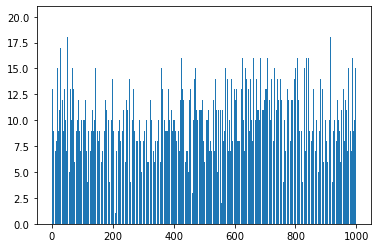

In [80]:
samples = {}
for i in range(10000):
    _,t = dg.__getitem__(i)
    #for t in gtp_labs:
    if t not in list(samples.keys()):
        samples[int(t)]=0
    samples[int(t)]+=1
plt.bar(list(samples.keys()),list(samples.values()))
plt.show()


In [83]:
np.max(x[4][5].numpy())

0.8588235294117648

In [84]:
np.max(np.random.normal(0,0.1,(64,64,3)))

0.3686156744827067

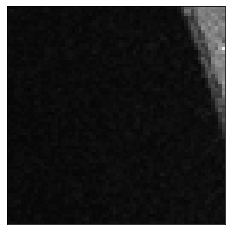

In [86]:
plt.imshow((x[4][5].numpy().transpose(1,2,0)+1)/2.0,cmap='gray')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False)

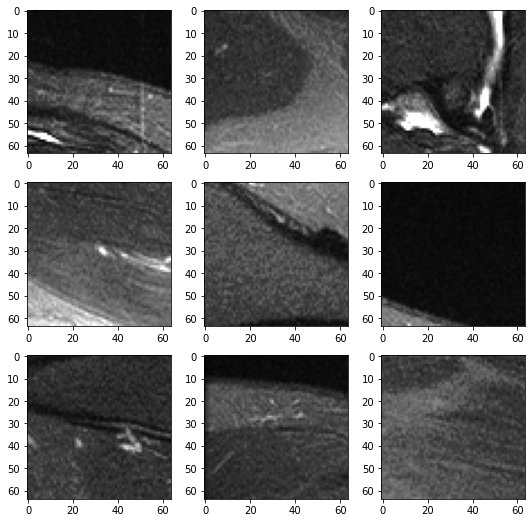

In [87]:
fig,axs=plt.subplots(3,3,figsize=(9,9))
for i in range(9):
    axs[int(i/3),i%3].imshow((np.transpose(x[4][i].numpy())+1)/2.0,cmap='gray')
    #axs[int(i/4),i%4].set_title(str(list(PPP_LABELS.keys())[ppp_labs[i]]))
plt.show()

In [88]:
x.shape

torch.Size([16, 9, 3, 64, 64])

## Manual Model

In [68]:
SEED = 0
seed_everything(SEED)

Global seed set to 0


### Skip and Dim Red Block

In [69]:
def conv3x3(inC,outC,stride=1,padding=1):
    return nn.Conv2d(inC,outC,kernel_size=3,stride = stride, padding = padding)

def conv1x1(inC,outC,stride=1,padding=1):
    return nn.Conv2d(inC,outC,kernel_size=1,stride = stride, padding = padding)

def norm_layer(inC):
    return nn.BatchNorm2d(inC)

def maxpool(kernel_size = 2, stride = 2):
    return nn.MaxPool2d(kernel_size = kernel_size, stride = stride)

def avgpool(output_size = 1):
    return nn.AdaptiveAvgPool2d(output_size = output_size)

In [70]:
class Skip_block(nn.Module):
    def __init__(self,inC,outC,upsample = 2,**kwargs):
        super(Skip_block, self).__init__()
        self.inC = inC
        self.outC = outC
        self.upsample = upsample
        try:
            self.scale  = kwargs['scale']
        except:
            self.scale = 1.0
        
        self.outC1 = self.outC//self.upsample
        self.outC2 = self.outC
        
        self.conv1 = conv3x3(self.inC,self.outC1)
        self.bn1 = norm_layer(self.outC1)
        self.conv2 = conv3x3(self.outC1, self.outC2)
        self.bn2 = norm_layer(self.outC2)
        self.relu = nn.ReLU(inplace = True)
        
    def forward(self,x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        #print("SKIP::",out.shape)
        out = self.scale*out + identity
        
        return out

class Dim_Red_block(nn.Module):
    def __init__(self,inC,outC,upsample = 1,**kwargs):
        super(Dim_Red_block,self).__init__()
        self.inC= inC
        self.upsample = upsample
        self.outC = outC
        
        self.outC1 = (self.outC//2)//self.upsample
        self.outC2 = self.outC//2
        
        try:
            self.downfactor = kwargs['downfactor']
        except:
            self.downfactor = 2
            
        if self.downfactor == 2:
            self.stride1 = 1
        elif self.downfactor == 4:
            self.stride1 = 2
        self.stride2 = 2
        
        self.conv11 = conv3x3(self.inC, self.outC1, stride = self.stride1)
        self.bn11 = norm_layer(self.outC1)
        self.relu11 = nn.ReLU()
        self.conv12 = conv3x3(self.outC1, self.outC2, stride = self.stride2)
        self.bn12 = norm_layer(self.outC2)
        self.relu12 = nn.ReLU()
        
        self.downsample21 = avgpool()
        self.conv22 = conv1x1(self.inC,self.outC2,padding = 0)
        self.bn22 = norm_layer(self.outC2)
        self.relu22 = nn.ReLU()
        
    def forward(self,x):
        out1 = self.conv11(x)
        out1 = self.bn11(out1)
        out1 = self.relu11(out1)
        #print("DIMRED:",out1.shape)
        out1 = self.conv12(out1)
        out1 = self.bn12(out1)
        out1 = self.relu12(out1)
        #print(out1.shape)
        
        out2 = nn.AdaptiveAvgPool2d(x.shape[-1]//self.downfactor)(x)
        out2 = self.conv22(out2)
        out2 = self.bn22(out2)
        out2 = self.relu22(out2)
        #new hcnage
        #print(out2.shape)
        
        out = torch.cat((out1,out2),dim=1)
         # new change
        return out

In [71]:
class Conv_block(nn.Module):
    def __init__(self,inC,outC,upsample = 1,**kwargs):
        super(Conv_block,self).__init__()
        self.inC = inC
        self.outC = outC
        self.upsample = upsample
        self.outC1 = self.outC // upsample
        self.outC2 = self.outC
        
        self.conv1 = conv3x3(self.inC,self.outC1)
        self.bn1 = norm_layer(self.outC1)
        self.conv2 = conv3x3(self.outC1,self.outC1)
        self.bn2 = norm_layer(self.outC1)
        self.conv3 = conv3x3(self.outC1,self.outC2)
        self.bn3 = norm_layer(self.outC2)
        self.conv4 = conv3x3(self.outC2,self.outC2)
        self.bn4 = norm_layer(self.outC2)
        self.relu = nn.ReLU(inplace = True)
        self.downsample = maxpool()
        
    def forward(self,x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.downsample(out)
        #print(out.shape)
        
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu(out)
        
        out = self.conv4(out)
        out = self.bn4(out)
        out = self.relu(out)
        
        out = self.downsample(out)
        #print(out.shape)
        
        return out

### Modified Model

In [72]:
class JPOP_net(nn.Module): 
    def __init__(self,
                 conv_block,
                 skip_block,
                 dim_red_block, 
                 layer_outs, 
                 upsampling_dict, 
                 downfactor = 2, 
                 scale = 1.0, 
                 input_shape = (3,64,64), 
                 num_classes = 500
                ):
        super(JPOP_net,self).__init__()
        self.conv_block = conv_block
        self.skip_block = skip_block
        self.dim_red_block = dim_red_block
        self.input_shape = input_shape
        self.inC = self.input_shape[0]
        self.num_classes = num_classes
        self.up_dict = upsampling_dict
        self.downfactor = downfactor
        self.scale = scale
        
        self.conv_channel1 = self._make_layer(self.conv_block,self.inC,layer_outs[0],self.up_dict['conv_block'])
        self.conv_channel2 = self._make_layer(self.conv_block,self.inC,layer_outs[0],self.up_dict['conv_block'])
        self.conv_channel3 = self._make_layer(self.conv_block,self.inC,layer_outs[0],self.up_dict['conv_block'])
        self.conv_channel4 = self._make_layer(self.conv_block,self.inC,layer_outs[0],self.up_dict['conv_block'])
        self.conv_channel5 = self._make_layer(self.conv_block,self.inC,layer_outs[0],self.up_dict['conv_block'])
        self.conv_channel6 = self._make_layer(self.conv_block,self.inC,layer_outs[0],self.up_dict['conv_block'])
        self.conv_channel7 = self._make_layer(self.conv_block,self.inC,layer_outs[0],self.up_dict['conv_block'])
        self.conv_channel8 = self._make_layer(self.conv_block,self.inC,layer_outs[0],self.up_dict['conv_block'])
        self.conv_channel9 = self._make_layer(self.conv_block,self.inC,layer_outs[0],self.up_dict['conv_block'])
        
        self.conv1x1layer = conv1x1(9*layer_outs[0],layer_outs[1],padding=0)
        self.bn1x1 = norm_layer(layer_outs[1])
        self.relu1x1 = nn.ReLU()
        
        self.skip_block1 = self._make_layer(self.skip_block,layer_outs[1],layer_outs[2],upsample = self.up_dict['skip1'],scale = self.scale) # conv3x3(layer_outs[1],layer_outs[3]) 
        
        self.dim_red_block1 = self._make_layer(self.dim_red_block,layer_outs[2],layer_outs[3], upsample = self.up_dict['dimred1'],downfactor = self.downfactor) # maxpool() #
        
        self.skip_block2 = self._make_layer(self.skip_block,layer_outs[3],layer_outs[4],upsample = self.up_dict['skip2'],scale = self.scale) # conv3x3(layer_outs[3], layer_outs[5]) 
        
        self.dim_red_block2 = self._make_layer(self.dim_red_block,layer_outs[4],layer_outs[5],upsample = self.up_dict['dimred2'],downfactor = self.downfactor) # maxpool() 
        
        self.globalavgpool = avgpool(1)
        
        self.projector = nn.Sequential(*[nn.Linear(layer_outs[5],1024),
                                        nn.ReLU(),
                                        nn.Linear(1024,self.num_classes)])
        #self.fc1 = 
        #self.fc2 = nn.Linear(1024,1024)
        #self.output = 

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    
    def _make_layer(self,block,inC,outC,upsample,**kwargs):
        layers = [block(inC,outC,upsample,**kwargs)]
        return nn.Sequential(*layers)
    
    def _forward_impl(self,x):
        #print(x.shape,x.select(1,0).shape)
        out1 = self.conv_channel1(x.select(1,0)) #.to(memory_format=torch.channels_last))
        out2 = self.conv_channel2(x.select(1,1)) #.to(memory_format=torch.channels_last))
        out3 = self.conv_channel3(x.select(1,2)) #.to(memory_format=torch.channels_last))
        out4 = self.conv_channel4(x.select(1,3)) #.to(memory_format=torch.channels_last))
        out5 = self.conv_channel5(x.select(1,4)) #.to(memory_format=torch.channels_last))
        out6 = self.conv_channel6(x.select(1,5)) #.to(memory_format=torch.channels_last))
        out7 = self.conv_channel7(x.select(1,6)) #.to(memory_format=torch.channels_last))
        out8 = self.conv_channel8(x.select(1,7)) #.to(memory_format=torch.channels_last))
        out9 = self.conv_channel9(x.select(1,8)) #.to(memory_format=torch.channels_last))
        
        out = torch.cat((out1,out2,out3,out4,out5,out6,out7,out8,out9),dim = 1)
        #print(out.shape)
        out = self.conv1x1layer(out)
        out = self.bn1x1(out)
        out = self.relu1x1(out)
        #print(out.shape)
        out = self.skip_block1(out)
        #print(out.shape)
        out = self.dim_red_block1(out)
        out = self.skip_block2(out)
        out = self.dim_red_block2(out)
        
        out = self.globalavgpool(out)
        #print(out.shape)
        out = torch.squeeze(out)
        #print(out.shape)
        out = self.projector(out)
        #out = self.fc1(out)
        #out = self.relu(out)
        #print(out.shape)
        #out = self.fc2(out)
        #out = self.relu(out)
        #print(out.shape)
        #out = self.output(out)
        
        return out
    
    def forward(self,x):
        return self._forward_impl(x)
    
def model(conv_block,skip_block,dim_red_block,layer_outs,upsampling_dict,
          input_shape = (3,64,64),num_classes = 500,scale = 1.0,downfactor = 2):
    
    return JPOP_net(conv_block,skip_block,dim_red_block,layer_outs,upsampling_dict,
                    downfactor = 2, scale = 0.25, input_shape = (3,64,64), num_classes = num_classes)

## Manual Training Loop

In [73]:
skidv1 = [256,1024,1024,1024,1024,4096]
skidv2 = [256,1024,1024,2048,2048,4096]
skidv3 = [256,1024,1024,2048,2048,4096]

skidv1_upsampling_dict = {'conv_block':1,'skip1':2,'dimred1':1,'skip2':2,'dimred2':1}
skidv2_upsampling_dict = {'conv_block':1,'skip1':2,'dimred1':1,'skip2':2,'dimred2':1}
skidv3_upsampling_dict = {'conv_block':1,'skip1':1,'dimred1':1,'skip2':1,'dimred2':1}

In [74]:
sag_rocket_model = model(Conv_block,
                         Skip_block,
                         Dim_Red_block,
                         skidv1,
                         skidv1_upsampling_dict, 
                         downfactor = 2, 
                         scale = 0.25, 
                         input_shape = (3,64,64), 
                         num_classes = NUM_CLASSES).cuda()
device = torch.device("cuda:0")


In [75]:
# sag_rocket_model = nn.DataParallel(sag_rocket_model)
# sag_rocket_model = sag_rocket_model.to(device)

In [76]:
# sag_rocket_model.load_state_dict(torch.load('/home/cvpr/Documents/Siladittya/sslm_saved_models/KneeMRI_JPOP_Net_rmsprop_280921__ep959.pt')['model_state_dict'])

In [77]:
# sag_rocket_model = sag_rocket_model.to(device)

In [78]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [79]:
count_parameters(sag_rocket_model)

108826856

In [67]:
# !python -m pip install prettytable

In [67]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(sag_rocket_model)

+--------------------------------+------------+
|            Modules             | Parameters |
+--------------------------------+------------+
|  conv_channel1.0.conv1.weight  |    6912    |
|   conv_channel1.0.conv1.bias   |    256     |
|   conv_channel1.0.bn1.weight   |    256     |
|    conv_channel1.0.bn1.bias    |    256     |
|  conv_channel1.0.conv2.weight  |   589824   |
|   conv_channel1.0.conv2.bias   |    256     |
|   conv_channel1.0.bn2.weight   |    256     |
|    conv_channel1.0.bn2.bias    |    256     |
|  conv_channel1.0.conv3.weight  |   589824   |
|   conv_channel1.0.conv3.bias   |    256     |
|   conv_channel1.0.bn3.weight   |    256     |
|    conv_channel1.0.bn3.bias    |    256     |
|  conv_channel1.0.conv4.weight  |   589824   |
|   conv_channel1.0.conv4.bias   |    256     |
|   conv_channel1.0.bn4.weight   |    256     |
|    conv_channel1.0.bn4.bias    |    256     |
|  conv_channel2.0.conv1.weight  |    6912    |
|   conv_channel2.0.conv1.bias   |    25

+--------------------------------+------------+
Total Trainable Params: 108314356


108314356

## Manual Training

In [71]:
# MAXLR = 0.0001
# def LRscheduler(epoch,lr):
#     global MAXLR
    
#     lr = 0.95*lr
    
#     epochrem = epoch%50
#     if epochrem==0 and epoch > 1:
#         MAXLR *= 0.25
#         lr = MAXLR
        
#     if lr < 5*10**(-6):
#         lr = 0.000005

#     return lr

In [80]:
tdg = PPPDataGen('train',
                 'sagittal',
                 mrnet_path,
                 tr_filenames_df,
                 preprocess_input = ppi_irv2,
                 ppp_labels_dict = PPP_LABELS,
                 gtp_labels_dict = GTP_LABELS,
                 batch_size=1,
                 num_frames = 16,
                 num_classes=NUM_CLASSES,
                 hor_flip = False,
                 data_aug = True, 
                 mrnet = True)

vdg = PPPDataGen('valid',
                 'sagittal',
                 mrnet_path,
                 val_filenames_df,
                 preprocess_input = ppi_irv2,
                 ppp_labels_dict = PPP_LABELS,
                 gtp_labels_dict = GTP_LABELS,
                 batch_size=1,
                 num_frames = 16,
                 num_classes=NUM_CLASSES,
                 hor_flip = False,
                 data_aug = False, 
                 mrnet = True)

tdl = DataLoader(tdg,batch_size=16, drop_last = True)
vdl = DataLoader(vdg,batch_size=16)

torch.Size([16, 9, 3, 64, 64])


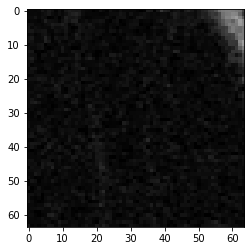

In [69]:
for x,y in vdl:
    print(x.shape)
    #print(x[0,0].numpy())
    plt.imshow((1+x[1,5].numpy().transpose((1,2,0)))/2)
    plt.show()
    break

In [81]:
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []
n_epochs = 50
N_train = len(tdl)
N_valid = len(vdl)
save_model_PATH = 'C:/Users/ISI_UTS/Siladittya/IEEE TAI/saved_models/'

In [82]:
def save_model(epoch,model,optimizer,train_acc,train_loss,valid_acc,valid_loss,model_name,save_path,exp_num):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
               'train_loss':train_loss, 'valid_loss':valid_loss,
               'train_accuracy':train_acc,'valid_accuracy':valid_acc}, save_path+model_name+str(exp_num)+'_'+str(epoch)+'.pt')
    return save_path+model_name+str(exp_num)+'_'+str(epoch)+'.pt'

In [83]:
from tabulate import tabulate 
def print_metrics(metrics):
    cols=['Training','Validation']
    metricskeys = list(metrics.keys())
    table = [[mk]+metrics[mk] for mk in metricskeys]
    table = tabulate(table,headers=cols,tablefmt='grid')
    print(table)

In [84]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.RMSprop([params for params in sag_rocket_model.parameters() if params.requires_grad],lr=0.0001)

In [85]:
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=1,gamma=0.95,last_epoch=-1)

In [ ]:
min_loss = np.Inf
for epoch in range(n_epochs):
    stime = time.time()
    print("============= Epoch : %3d ============="%(epoch+1))
    loss_sublist = []
    acc_sublist = []
    yhats = 0
    correct = 0
    sag_rocket_model.train()
    for x,y in tdl:
        sag_rocket_model.train()
        x,y = x.to(device = device, dtype = torch.float),y.to(device = device)
        optimizer.zero_grad(set_to_none = True)
        z = sag_rocket_model(x)
        #print(z.shape)
        tr_loss = loss_fn(z,y)
        tr_loss.backward()
        optimizer.step()
        loss_sublist.append(tr_loss.data.item())
        
    train_loss.append(np.mean(loss_sublist))
    
    loss_sublist = []
    acc_sublist = []
    correct = 0
    sag_rocket_model.eval()
    with torch.no_grad():
        for x,y in tdl:
            z = sag_rocket_model(x.cuda().float())
            _,yhat = torch.max(z.data,1)
            #yhats+=len(yhat)
            correct +=(yhat.cpu()==y).sum().item()
        tr_accuracy=correct/(N_train)
    #print(len(yhats))
    train_acc.append(tr_accuracy)
    
    correct = 0    
    with torch.no_grad():
        for x,y in vdl:
            # x,y = x.to(device = device, dtype = torch.float),y.to(device = device)
            z = sag_rocket_model(x.cuda().float())
            val_loss = loss_fn(z,y.cuda())
            loss_sublist.append(val_loss.data.item())

            _,yhat = torch.max(z.data,1)
            correct +=(yhat.cpu()==y).sum().item()
        val_accuracy=correct/(N_valid)
        
    valid_acc.append(val_accuracy)    
    valid_loss.append(np.mean(loss_sublist))
    
    lr_scheduler.step()

    print_metrics({'Accuracy':[train_acc[-1],valid_acc[-1]],'Loss':[train_loss[-1],valid_loss[-1]]})
    print("Time taken for Epoch %3d : %.3f minutes"%(epoch+1,(time.time()-stime)/60))
    print("Saving Model...")
    if valid_loss[-1] <= min_loss:
        min_loss = valid_loss[-1]
        min_val_path = save_model(epoch+1,sag_rocket_model,optimizer,train_acc,train_loss,valid_acc,valid_loss,'SKIDv1_MRNet_',save_model_PATH,1)

============= Epoch :   1 =============
+----------+------------+--------------+
|          |   Training |   Validation |
+==========+============+==============+
| Accuracy |   0.653097 |     0.633333 |
+----------+------------+--------------+
| Loss     |   6.43965  |     5.31941  |
+----------+------------+--------------+
Time taken for Epoch   1 : 16.447 minutes
Saving Model...
============= Epoch :   2 =============
+----------+------------+--------------+
|          |   Training |   Validation |
+==========+============+==============+
| Accuracy |    2.14779 |      2.04167 |
+----------+------------+--------------+
| Loss     |    4.55293 |      3.80505 |
+----------+------------+--------------+
Time taken for Epoch   2 : 16.217 minutes
Saving Model...
============= Epoch :   3 =============
+----------+------------+--------------+
|          |   Training |   Validation |
+==========+============+==============+
| Accuracy |    3.49027 |      3.525   |
+----------+------------+-

In [77]:
!nvidia-smi

Wed Aug 24 19:58:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.15       Driver Version: 512.15       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000   WDDM  | 00000000:01:00.0  On |                  Off |
| 30%   41C    P8    13W / 230W |  19735MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [56]:
# save_model(epoch+1,sag_rocket_model,optimizer,train_acc,train_loss,valid_acc,valid_loss,'Sagittal_JPOP_Net',save_model_PATH)

In [ ]:
plt.plot([t for t in train_acc])
plt.plot([v for v in valid_acc])
plt.show()

In [ ]:
plt.plot(train_loss)
plt.plot(valid_loss)
plt.show()

# Downstream

### ConvLSTM

In [ ]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.
        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)
        

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

In [ ]:
# for p in sag_rocket_model.parameters():
#     p.requires_grad = False

# sag_rocket_model.globalavgpool = nn.Identity()
# sag_rocket_model.projector = nn.Sequential([ConvLSTM(4096, 512, 3, 1, True, True, True), ConvLSTM(512, 512, 3, 1 ,True)])


In [ ]:
class ConvLSTM(nn.Module):

    """
    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.
    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

### DS Model

In [ ]:
class DSModel(nn.Module):
    def __init__(self, premodel, num_classes):
        super().__init__()
        self.premodel = premodel.cuda()
        for p in self.premodel.parameters():
            p.requires_grad = False
        
        self.num_classes = num_classes
        
        self.premodel.globalavgpool = nn.Identity()
        self.premodel.projector = nn.Identity()

        self.convlstm2d_1 = ConvLSTM(4096, 512, (3,3), 1, True).cuda()
        self.convlstm2d_2 = ConvLSTM(512, 512, (3,3), 1 ,True).cuda()
        self.gap = nn.AdaptiveAvgPool2d(1).cuda()
        self.fc = nn.Linear(512,self.num_classes).cuda()
        #self.relu = nn.ReLU().to('cuda:1')
        #self.sigmoid = nn.Sigmoid().to('cuda:1')

    def forward(self,x):
        x = self.premodel(x)
        #print(x.shape)
        x = x.unsqueeze(0)
        #print(x.shape)
        x,_ = self.convlstm2d_1(x)
        x,_ = self.convlstm2d_2(x[0])
        #print(len(x),x[0].shape)
        x = x[0][-1][-1]
        #print(x.shape, x[-1].shape)
        #print(x.shape)
        x = torch.squeeze(self.gap(x)).unsqueeze(0)
        x = self.fc(x)
        #x = self.sigmoid(x)
        return x

In [ ]:
# for n, p in dsmodel.premodel.module.named_parameters():
#     print(n, p.requires_grad)
    

In [ ]:
# dsmodel.premodel.module

### Class weights

In [ ]:
# #np.unique(inference_df['aclDiagnosis'].values)
# kneemri2 = np.count_nonzero(train_df['aclDiagnosis'].values==2)
# kneemri1 = np.count_nonzero(train_df['aclDiagnosis'].values==1)
# kneemri0 = np.count_nonzero(train_df['aclDiagnosis'].values==0)
# print(kneemri2, kneemri1, kneemri0)

# cw = np.array([[kneemri0, kneemri1, kneemri2]])
# cw = cw/np.sum(cw,axis =1 , keepdims = True)
# cw = 1/cw
# cw = cw/np.min(cw, axis = 1, keepdims = True)
# print(cw)

In [ ]:
abnNUM_1 = np.count_nonzero(tr_multilabel['abn']==1)
abnNUM_0 = np.count_nonzero(tr_multilabel['abn']==0)
print(abnNUM_1,abnNUM_0)
aclNUM_1 = np.count_nonzero(tr_multilabel['acl']==1)
aclNUM_0 = np.count_nonzero(tr_multilabel['acl']==0)
print(aclNUM_1,aclNUM_0)
menNUM_1 = np.count_nonzero(tr_multilabel['men']==1)
menNUM_0 = np.count_nonzero(tr_multilabel['men']==0)
print(menNUM_1,menNUM_0)

In [ ]:
cw = np.array([[abnNUM_1,abnNUM_0],[aclNUM_1,aclNUM_0],[menNUM_1,menNUM_0]])
cw = cw/np.sum(cw,axis=1,keepdims=True)
#cw *= 2
cw = 1/cw
cw = cw/np.min(cw,axis=1,keepdims=True)
print(cw)

In [96]:
# cw = cw[1,:]
# print(cw)

0.1


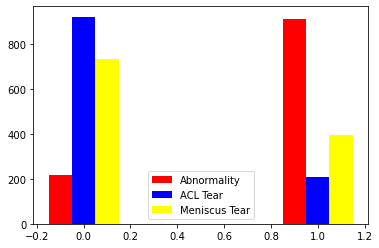

In [97]:
fig, ax = plt.subplots()

abn_heights, abn_bins = np.histogram(tr_multilabel['abn'],bins=[-0.5,0.5,1.5])
acl_heights, acl_bins = np.histogram(tr_multilabel['acl'], bins=abn_bins)
men_heights, men_bins = np.histogram(tr_multilabel['men'], bins=acl_bins)

width = (abn_bins[1] - abn_bins[0])/10.0
print(width)

ax.bar(abn_bins[:-1]-width+0.5, abn_heights, width=width, facecolor='red')
ax.bar(acl_bins[:-1]+0.5, acl_heights, width=width, facecolor='blue')
ax.bar(men_bins[:-1]+width+0.5, men_heights, width=width, facecolor='yellow')

ax.legend(['Abnormality','ACL Tear','Meniscus Tear'])

## DS Datagen

In [76]:
NUM_FRAMES = 16
NUM_CLASSES = 3

In [77]:
# filepath = inference_df['volumeFilepath'].iloc[0]
# with open(filepath,'rb') as file_handler:
#     npy_file = pickle.load(file_handler)
#     print(npy_file.shape)

In [ ]:
def ppi_irv2(x):
    x /= 127.5
    x -= 1.
    return x

class DSDataGen(Dataset):
    def __init__(self, phase, injury, mode, base_dir, labs_df, filenames_df, preprocess_input = None, 
                 batch_size=1, data_aug = True, num_frames = NUM_FRAMES, num_classes=NUM_CLASSES, mrnet = True):
        self.base_dir = base_dir
        self.ph_mode_dir = base_dir +'/'+phase
        #self.filenames = os.listdir(self.ph_mode_dir)
        self.phase = phase
        self.batch_size = batch_size
        self.num_frames = num_frames
        self.num_classes = num_classes
        self.filenames_df = filenames_df
        self.preprocess_input = preprocess_input
        #self.pretext_model = pretext_model
        self.MAX_FRAMES = num_frames #NUM_FRAMES
         
        self.mode = mode #['sagittal','coronal','axial']

        self.mllabs = labs_df

        self.indices = list(range(self.filenames_df.shape[0]))
        
        self.data_aug = data_aug
        
        self.startind = 0
        self.endind = self.startind + self.batch_size
        
        self.invGamma100 = 1.0 
        self.invGamma115 = 1.0/1.15
        self.invGamma085 = 1.0/0.85
        self.table100 = np.array([((k / 255.0) ** self.invGamma100) * 255 for k in np.arange(0, 256)]).astype("uint8")
        self.table115 = np.array([((k / 255.0) ** self.invGamma115) * 255 for k in np.arange(0, 256)]).astype("uint8")
        self.table085 = np.array([((k / 255.0) ** self.invGamma085) * 255 for k in np.arange(0, 256)]).astype("uint8")
        self.gamma_dict100 = dict(zip(range(256),self.table100))
        self.gamma_dict115 = dict(zip(range(256),self.table115))
        self.gamma_dict085 = dict(zip(range(256),self.table085))
        
        self.mrnet = mrnet
        
        if self.mrnet:
            self.injury = injury #['abn','acl','men']
        else:
            self.injury = injury #['aclDiagnosis']

    def get_random_shuffle_order(self,batch_sz):
        blist = list(range(batch_sz))
        random.shuffle(blist)
        #print(blist)
        return blist
    
    def load_volume(self,mode,file_idx):
        
        if self.mrnet:
            filePoolLen = self.filenames_df.shape[0]
            #print(file_idx)
            #file_idx = file_idx%filePoolLen 
            npy_file = np.load(self.ph_mode_dir+'/'+mode+'/'+self.filenames_df['filename'].iloc[file_idx])
        
        else:
            filepath = self.filenames_df['volumeFilepath'].iloc[file_idx]
            #self.ph_mode_dir+'/'+self.filenames_df['volumeFilename'].iloc[file_idx]
            with open(filepath,'rb') as file_handler:
                npy_file = pickle.load(file_handler)
        
        return npy_file
    
    def get_frames(self,mode,idx):
        image_volume = self.load_volume(mode,idx)
        tot_frames = image_volume.shape[0]
        #print(tot_frames)
        if tot_frames < self.MAX_FRAMES:
            self.num_frames = tot_frames
            frame_idxs = np.array(list(range(self.num_frames)))
        else:
            self.num_frames = self.MAX_FRAMES
            #self.num_frames = 9*int(np.floor(self.num_frames/9.))
            #print(frame_idxs.shape)
            lnum_frames = int(self.num_frames//3)//2
            rnum_frames = int(self.num_frames//3)//2
            mnum_frames = int(2*self.num_frames//3)
            ltot_frames = int(tot_frames//3)//2
            rtot_frames = int(tot_frames//3)//2
            mtot_frames = int(2*tot_frames//3)

            #print(lnum_frames,mnum_frames,rnum_frames)
            #print(ltot_frames,mtot_frames,rtot_frames)

            frame_idxs = random.sample(list(range(ltot_frames)),lnum_frames)\
                        +random.sample(list(range(ltot_frames,ltot_frames+mtot_frames)),mnum_frames)\
                        +random.sample(list(range(ltot_frames+mtot_frames,ltot_frames+mtot_frames+rtot_frames)),rnum_frames)

            #print(frame_idxs)
            #ONLY FOR STANFORD MODEL
            frame_idxs = np.array(sorted(frame_idxs))

        frames = np.array([]).reshape((0,256,256,3))
        for n in range(frame_idxs.shape[0]):
            frame_idx = frame_idxs[n]
            frame = np.array(image_volume[frame_idx,:,:])
            
            if not self.mrnet:
                if np.max(frame) > 0.0:
                    frame = 255*(frame/np.max(frame))
                else:
                    frame = np.zeros(frame.shape, dtype = np.float32)
                #print(frame)
                frame = resize(frame, (256,256), preserve_range = True)
                
            frame = np.expand_dims(frame,axis=2)
            frame = np.append(frame,np.append(frame,frame,axis=2),axis=2)
            
            frames = np.append(frames,np.expand_dims(frame,axis=0),axis=0)
        #print(frames.shape)
        return frames
    
    def __len__(self):
        return len(self.filenames_df)
    
    def __getitem__(self,idx):
        
        #DECLARE VARIABLES
        # idx = idx%8
        batch_imgs = np.array([]).reshape((0,256,256,3))
        
        ds_batch_labs = self.mllabs[self.injury].iloc[idx].values.reshape(-1)
        
        #GET CLIP FRAMES
        batch_imgs = np.append(batch_imgs,self.get_frames(self.mode,idx),axis=0)

        sind = 0
        eind = 0
        tot_frames = batch_imgs.shape[0]

        #AUGMENT FRAMES
        if self.data_aug and self.phase == 'train':
            batch_imgs = self.__augment(batch_imgs)

        #PREPROCESS FRAMES
        batch_imgs = self.preprocess_input(batch_imgs)
        batch_imgs = np.transpose(batch_imgs,(0,3,1,2))
        #sagittal_rocket_imgs[i] = np.clip(sagittal_rocket_imgs[i] + np.random.normal(0,0.01,sagittal_rocket_imgs[i].shape),0,1.0)
        pre_inputs = np.repeat(np.expand_dims(batch_imgs,1),9,1)
        #inputs = self.pretext_model(pre_inputs)
        #inputs = tf.reshape(inputs,(1,16,16,16,256))
                    
        return pre_inputs, ds_batch_labs 
    
    def on_epoch_end(self):
        idx = np.random.permutation(self.filenames_df.index.values)
        self.mllabs = self.mllabs.reindex(idx)
        self.filenames_df = self.filenames_df.reindex(idx)
        self.mllabs = self.mllabs.reset_index(drop=True)
        self.filenames_df = self.filenames_df.reset_index(drop=True)
        
    def gamma_correction(self,temp_patch):
        
        gamma_val = np.random.choice([0,1,2])
        if gamma_val == 0:
            temp_patch = np.vectorize(self.gamma_dict100.get)(temp_patch.astype('int'))
        if gamma_val == 1:
            temp_patch = np.vectorize(self.gamma_dict115.get)(temp_patch.astype('int'))
        if gamma_val == 2:
            temp_patch = np.vectorize(self.gamma_dict085.get)(temp_patch.astype('int'))

        return temp_patch
    
    def __augment(self,batch_imgs):
        num_imgs = batch_imgs.shape[0]
        #rotang = np.random.choice([-20,0,20])
        scale = np.random.choice([1,1.15])
        transformation_matrix=np.array([[scale,           0,             np.random.choice([-15,0,15])],
                                        [0,               scale,         np.random.choice([-15,0,15])],
                                        [0,               0,                       1                 ]])
        for i in range(num_imgs):
            #batch_imgs[i] = rotate(batch_imgs[i],rotang,preserve_range=True)
            batch_imgs[i] = warp(batch_imgs[i], AffineTransform(matrix=transformation_matrix).inverse, preserve_range=True)
            #print(batch_labs)
                
        return batch_imgs

In [79]:
# NUM_1 = np.count_nonzero(tr_multilabel['acl']==1)
# NUM_0 = np.count_nonzero(tr_multilabel['acl']==0)
# min_class = np.argmin(np.array([NUM_0,NUM_1]))
# if int(min_class) == 0:
#     gapnum = (1130-NUM_0)-NUM_0
#     INDICES = tr_multilabel[tr_multilabel['acl']==0].index.values
#     INDICES = np.random.choice(list(INDICES),gapnum)
# else:
#     gapnum = (1130-NUM_1)-NUM_1
#     INDICES = tr_multilabel[tr_multilabel['acl']==1].index.values
#     INDICES = np.random.choice(list(INDICES),gapnum)
    
# tr_acl_multilabel = tr_multilabel.append(tr_multilabel.iloc[INDICES,:],ignore_index=True)
# tr_acl_filenames_df = tr_filenames_df.append(tr_filenames_df.iloc[INDICES,:],ignore_index=True)

# idx = np.random.permutation(tr_acl_filenames_df.index.values)
# tr_acl_multilabel = tr_acl_multilabel.reindex(idx)
# tr_acl_filenames_df = tr_acl_filenames_df.reindex(idx)
# tr_acl_multilabel = tr_acl_multilabel.reset_index(drop=True)
# tr_acl_filenames_df = tr_acl_filenames_df.reset_index(drop=True)

# print(len(tr_acl_multilabel))
# print(len(tr_acl_filenames_df))

In [80]:
# NUM_1 = np.count_nonzero(train_df['aclDiagnosis']==1)
# NUM_0 = np.count_nonzero(train_df['aclDiagnosis']==0)
# min_class = np.argmin(np.array([NUM_0,NUM_1]))
# if int(min_class) == 0:
#     gapnum = (len(train_df)-NUM_0)-NUM_0
#     INDICES = train_df[train_df['aclDiagnosis']==0].index.values
#     INDICES = np.random.choice(list(INDICES),gapnum)
# else:
#     gapnum = (len(train_df)-NUM_1)-NUM_1
#     INDICES = train_df[train_df['aclDiagnosis']==1].index.values
#     INDICES = np.random.choice(list(INDICES),gapnum)
    
# train_acl_df = train_df.append(train_df.iloc[INDICES,:],ignore_index=True)
# train_acl_df = train_df.append(train_df.iloc[INDICES,:],ignore_index=True)

# idx = np.random.permutation(train_acl_df.index.values)
# train_acl_df = train_acl_df.reindex(idx)
# #train_acl_df = train_acl_df.reindex(idx)
# train_acl_df = train_acl_df.reset_index(drop=True)
# #tr_acl_filenames_df = tr_acl_filenames_df.reset_index(drop=True)

# #print(len(tr_acl_multilabel))
# print(len(train_acl_df))

In [81]:
# #NUM_2 = np.count_nonzero(train_df['aclDiagnosis']==2)
# NUM_1 = np.count_nonzero(train_df['aclDiagnosis']==1)
# NUM_0 = np.count_nonzero(train_df['aclDiagnosis']==0)
# max_class = np.argmin(np.array([NUM_0,NUM_1])) #,NUM_2]))

# gapnum = NUM_0-NUM_1
# INDICES = train_df[train_df['aclDiagnosis']==1].index.values
# INDICES = np.random.choice(list(INDICES),gapnum)
# train_acl_df = train_df.append(train_df.iloc[INDICES,:],ignore_index=True)
# train_acl_df = train_df.append(train_df.iloc[INDICES,:],ignore_index=True)

# # gapnum = NUM_0-NUM_2
# # INDICES = train_df[train_df['aclDiagnosis']==2].index.values
# # INDICES = np.random.choice(list(INDICES),gapnum)
# # train_acl_df = train_acl_df.append(train_df.iloc[INDICES,:],ignore_index=True)
# # train_acl_df = train_acl_df.append(train_df.iloc[INDICES,:],ignore_index=True)

# idx = np.random.permutation(train_acl_df.index.values)
# train_acl_df = train_acl_df.reindex(idx)
# #train_acl_df = train_acl_df.reindex(idx)
# train_acl_df = train_acl_df.reset_index(drop=True)
# #tr_acl_filenames_df = tr_acl_filenames_df.reset_index(drop=True)

# #print(len(tr_acl_multilabel))
# print(len(train_acl_df))

In [82]:
# plt.hist(train_acl_df['aclDiagnosis'].values)

NameError: name 'train_acl_df' is not defined

In [ ]:
mrnetclasses = ['abn','acl','men']
kneemriclasses = ['aclDiagnosis']
tdg = DSDataGen('train', mrnetclasses, 'sagittal',
                mrnet_path, tr_multilabel, tr_filenames_df, 
                preprocess_input = ppi_irv2,
                batch_size=1, num_frames = 16,
                num_classes=NUM_CLASSES,
                data_aug = True, mrnet = True)
vdg = DSDataGen('valid', mrnetclasses, 'sagittal',
                mrnet_path, val_multilabel, val_filenames_df,
                preprocess_input = ppi_irv2,
                batch_size=1, num_frames = 16,
                num_classes=NUM_CLASSES,
                data_aug = False, mrnet = True)

In [ ]:
tdl = DataLoader(tdg, batch_size = 1)
vdl = DataLoader(vdg, batch_size = 1)

In [ ]:
N_train = len(tdl)
N_valid = len(vdl)

In [ ]:
# sag_rocket_model

In [ ]:
sag_rocket_model.load_state_dict(torch.load(min_val_path)['model_state_dict'], strict = False)

In [ ]:
dsmodel = DSModel(sag_rocket_model, 3)

In [ ]:
cw

In [ ]:
pos_wts = torch.from_numpy(np.array(cw[:,0]).reshape((-1,1))).to('cuda:0')
pos_wts.requires_grad = False
neg_wts = torch.from_numpy(np.array(cw[:,1]).reshape((-1,1))).to('cuda:0')
neg_wts.requires_grad = False

In [ ]:
def weighted_bce_loss(y_pred, y_true):
    
    #print(pos_wts, neg_wts)
    loss = - torch.mul(torch.mul(pos_wts, y_true), torch.log(y_pred))
    loss = loss - torch.mul(torch.mul(neg_wts, 1 - y_true), torch.log(1 - y_pred))
    loss = loss.sum()
    return loss

loss_fn = weighted_bce_loss

In [ ]:
cw = torch.from_numpy(cw).reshape((-1,3)).to(device = 'cuda:0', dtype = torch.float)
cw.requires_grad = False

In [ ]:
cw

In [ ]:
loss_fn = nn.BCEWithLogitsLoss().to('cuda:0') #nn.CrossEntropyLoss().to('cuda:1') #

optimizer = torch.optim.RMSprop([params for params in dsmodel.parameters() if params.requires_grad],lr=0.00001)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=1,gamma=0.95,last_epoch=-1)

In [112]:
import torchinfo

In [115]:
# torchinfo.summary(dsmodel, (16, 9, 3, 64, 64))

In [ ]:
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

In [132]:
N_valid

960

In [ ]:
save_model_PATH = 'C:/Users/ISI_UTS/Siladittya/IEEE TAI/saved_models/'

In [ ]:
min_loss = np.Inf

In [ ]:
for epoch in range(20):
    stime = time.time()
    print("============= Epoch : %3d ============="%(epoch+1))
    loss_sublist = []
    acc_sublist = []
    yhats = 0
    correct = 0
    #sag_rocket_model.train()
    for x,y in tdl:
        #print(y)
        dsmodel.train()
        x,y = x.to(device = 'cuda:0', dtype = torch.float),y.to(device = 'cuda:0', dtype = torch.float)
        x = x.squeeze(0)
        optimizer.zero_grad(set_to_none = True)
        z = dsmodel(x)
        #print(z,y)
        tr_loss = loss_fn(z,y)#.view(-1))
        #print(tr_loss)
        tr_loss.backward()
        optimizer.step()
        loss_sublist.append(tr_loss.data.item())
         
    train_loss.append(np.mean(loss_sublist))
    
    loss_sublist = []
    acc_sublist = []
    correct = 0
    dsmodel.eval()
    with torch.no_grad():
        for x,y in tdl:
            x,y = x.to(device = 'cuda:0', dtype = torch.float),y.to(device = 'cuda:0', dtype = torch.float)
            x = x.squeeze(0)
            z = dsmodel(x)
            tr_loss = loss_fn(z,y)#.view(-1))
            loss_sublist.append(tr_loss.data.item())

            #_,yhat = torch.max(z.data,1)
            yhat = (z.data>=0.5)
            correct +=(yhat==y).sum().item()
        accuracy=correct/(3*N_train)
        
    train_acc.append(accuracy)
        
    loss_sublist = []
    acc_sublist = []
    correct = 0
    with torch.no_grad():
        for x,y in vdl:
            x,y = x.to(device = 'cuda:0', dtype = torch.float),y.to(device = 'cuda:0', dtype = torch.float)
            x = x.squeeze(0)
            z = dsmodel(x)
            val_loss = loss_fn(z,y)#.view(-1))
            loss_sublist.append(val_loss.data.item())

            #_,yhat = torch.max(z.data,1)
            yhat = (z.data>=0.5)
            correct +=(yhat==y).sum().item()
        accuracy=correct/(3*N_valid)
        
    valid_acc.append(accuracy)    
    valid_loss.append(np.mean(loss_sublist))
    
    lr_scheduler.step()
    
    tdg.on_epoch_end()

    print_metrics({'Accuracy':[train_acc[-1],valid_acc[-1]],'Loss':[train_loss[-1],valid_loss[-1]]})
    print("Time taken for Epoch %3d : %.3f minutes"%(epoch+1,(time.time()-stime)/60))
    print("Saving Model...")
    if valid_loss[-1] <= min_loss:
        min_loss = valid_loss[-1]
        min_val_path = save_model(epoch+1,dsmodel,optimizer,train_acc,train_loss,valid_acc,valid_loss,'SKIDv1_MRNet_DS_',save_model_PATH+'/',1)

In [60]:
z

tensor([[3.9177]], device='cuda:1', grad_fn=<AddmmBackward>)

In [122]:
# save_model(epoch+1,dsmodel,optimizer,train_acc,train_loss,valid_acc,valid_loss,'SKIDv1_MRNet_DS_',save_model_PATH+'/',1)

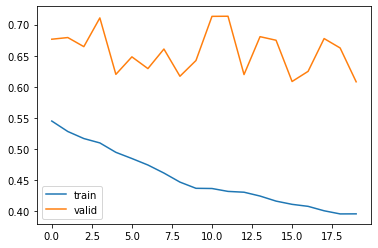

In [146]:
plt.plot([t for t in train_loss])
plt.plot([v for v in valid_loss])
plt.legend(['train','valid'])

In [ ]:
dsmodel.load_state_dict(torch.load(min_val_path)['model_state_dict'])

In [ ]:
preds = np.zeros((120,3))#.reshape((0,3))
gt = val_multilabel[['abn','acl','men']].values#np.array([]).reshape((0,3))
correct = 0
dsmodel.eval()
with torch.no_grad():
    for i in range(8):
        j=0
        for x,y in vdl:
            x,y = x.to(device = 'cuda:0', dtype = torch.float),y.to(device = 'cuda:0', dtype = torch.float)
            x = x.squeeze(0)
            z = dsmodel(x)
            preds[j] = preds[j] + z.detach().cpu().numpy() #p.append(preds,z.detach().cpu().numpy(), axis = 0)
            j+=1
            #gt = np.append(gt,y.cpu().numpy(), axis = 0)
            #val_loss = loss_fn(z,y)

In [ ]:
preds = preds/8

In [ ]:
#preds

In [ ]:
get_performance_metrics(gt, preds, ['ABN','ACL','MEN'])

In [ ]:
get_confidence_intervals(gt,preds, ['ABN','ACL','MEN'])

In [ ]:
get_roc_curve(gt, preds, ['ABN','ACL','MEN'])

In [63]:
np.save('mm_sagittal_preds.npy', preds)

In [61]:
tsdg = DSDataGen('', kneemriclasses, 'sagittal',
                kneemri_path, test_df, test_df,
                preprocess_input = ppi_irv2,
                batch_size=1, num_frames = 16,
                num_classes=NUM_CLASSES,
                data_aug = False,
                mrnet = False)
tsdl = DataLoader(tsdg, batch_size = 1)

In [62]:
preds = np.zeros((len(test_df),1)) #3))#.reshape((0,3))
gt = test_df[['aclDiagnosis']].values 
#nn.functional.one_hot(torch.from_numpy(test_df[['aclDiagnosis']].values),3)#np.array([]).reshape((0,3))
correct = 0
softmax = nn.Sigmoid().to('cuda:1') #nn.Softmax(dim=1).to('cuda:1') #
dsmodel.eval()
with torch.no_grad():
    for i in range(8):
        j=0
        for x,y in tsdl:
            x,y = x.to(device = 'cuda:0', dtype = torch.float),y.to(device = 'cuda:1', dtype = torch.float)
            x = x.squeeze(0)
            z = dsmodel(x)
            z = softmax(z)
            preds[j] = preds[j] + z.detach().cpu().numpy() #p.append(preds,z.detach().cpu().numpy(), axis = 0)
            j+=1
            #gt = np.append(gt,y.cpu().numpy(), axis = 0)
            #val_loss = loss_fn(z,y)
    preds = preds/8
    #_, preds = torch.max(preds, 1)

In [105]:
_, preds = torch.max(torch.from_numpy(preds), 1)

In [98]:
preds

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        1, 0, 0, 0, 1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
        0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1])

In [100]:
test_df[['aclDiagnosis']].values

array([[0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [2],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [2],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [2],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [2],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [2],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [2],
       [0],
       [0],
       [1],
       [2],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
    

In [106]:
correct = 0
for i in range(len(test_df)):
    if test_df[['aclDiagnosis']].values[i,0] == preds[i]:
        correct+=1
correct /= len(test_df)
print(correct)

0.574468085106383


In [63]:
get_performance_metrics(test_df[['aclDiagnosis']].values, preds, ['ACL']) #['ABN','ACL','MEN'])

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
Injury,,,,,,,,,,,,,
ACL,1,169,7,11,0.904,0.064,0.083,0.96,0.125,0.939,0.741,0.1,0.5


In [71]:
gt.shape

torch.Size([188, 1, 3])

In [73]:
get_confidence_intervals(test_df[['aclDiagnosis']].values,preds, ['ACL']) #['ABN','ACL','MEN'])

{'AUC':     Mean AUC (CI 5%-95%)
 ACL     0.76 (0.72-0.80),
 'Sensitivity':     Mean Sensitivity (CI 5%-95%)
 ACL             0.00 (0.00-0.00),
 'Specificity':     Mean Specificity (CI 5%-95%)
 ACL             0.99 (0.98-0.99),
 'Accuracy':     Mean Accuracy (CI 5%-95%)
 ACL          0.93 (0.92-0.93)}

In [67]:
z

tensor([[1.]], device='cuda:1')